# Data-Driven "Replay" Simulation
 
This notebook demonstrates how to use the "data-driven" or "trace-based" simulation approach. Instead of using synthetic data for PV and Load, we use real-world data from actual microgrids.


## Importing Libraries and Our Simulator

In [1]:
import sys, os

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Using project_root:", project_root)

Using project_root: c:\Users\olanr\Downloads\course-proj\microgrid-control-sim


In [2]:
# Import simulation components
from microgrid_sim.core import MicrogridEnv
from microgrid_sim.components.generators import PVGenerator, WindTurbine, GridIntertie, ReplayGenerator
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import FactoryLoad
from microgrid_sim.utils import plot_simulation
from microgrid_sim.types import DataBuilder

# Import the new data builders
from microgrid_sim.data import MesaDataBuilder, LiegeDataBuilder

# Import the controller
from microgrid_sim.control import RuleBasedEMS
from microgrid_sim.control.rules import BatteryRule, GridRule, RenewableDisconnectRule

## General Constants

In [3]:
# Total duration of the simulation in hours.
total_hours = 24 * 7 # 7 days

# Control interval (in minutes): How often the EMS (controller) makes a new decision.
control_dt = 60

# Simulation timestep (in minutes): The fidelity of the physics calculation.
sim_dt = 60

# Helper variable: Converts `sim_dt` to hours for energy calculations (e.g., kW -> kWh).
dt_hours = sim_dt / 60.0

# Heuristic for battery sizing: e.g., "size the battery to cover 4 hours of its max load".
bat_hr_sizing = 4

# Random seed for data builders to ensure reproducible (identical) results.
seed = 5

## Scenario 1 - Mesa Del Sol Data Replay

### Data Generation & Component Definitions

In [4]:
print("\n Starting Scenario 1: Mesa Del Sol")

MESA_DATA_PATH = "../data/mesa"
data_builder_mesa: DataBuilder = MesaDataBuilder(
    csv_folder_path = MESA_DATA_PATH,
    total_hours = total_hours,
    sim_dt_minutes = sim_dt,
    seed = seed
)

# Build the exogenous data list
exog_list_mesa = data_builder_mesa.build_list()
print(f"Built {len(exog_list_mesa)} steps of data from Mesa Del Sol.")

pv_mesa = ReplayGenerator("pv", time_step_minutes=sim_dt)

max_bat_kw_mesa = 50.0
bat_mesa = BatteryStorage("bat", capacity_kwh=max_bat_kw_mesa*bat_hr_sizing, time_step_minutes=sim_dt, initial_soc=0.5)
site_load_mesa = FactoryLoad("site_load", data_driven=True)

grid_mesa = GridIntertie("grid", time_step_minutes=sim_dt,
                         price_import_per_kwh=0.20, price_export_per_kwh=0.05,
                         import_limit_kw=None)


 Starting Scenario 1: Mesa Del Sol
Loading and concatenating all Mesa Del Sol CSVs...
Cleaning raw data. Clamping PV to [0.0, 50.0] kW.
Clamping Load to [0.0, 250.0] kW.
Resampling data...
Randomly selected start date: 2022-11-27T00:00:00.000000000
Note: Grid price data not included. Using synthetic prices.
Built 168 steps of data from Mesa Del Sol.


c:\Users\olanr\Downloads\course-proj\microgrid-control-sim\microgrid_sim\data\mesa_builder.py:90: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_raw.resample(self.resample_str).mean().ffill().bfill()


### Build and Run Environment with Simple Controller

Environment 1 (Mesa) built with data-driven components.
Running Mesa data-driven simulation...


Mesa simulation complete.
Scenario 4 Total Cost: $-2489.59
Scenario 4 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,pv_downtime,grid_power,grid_cost,grid_downtime,bat_power,bat_cost,bat_soc,bat_downtime,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step (sim_dt),,,,,,,,,,,,,,,,,,,,,
163,0.0,0.0,0.0,99.835835,-31.059193,0.0,10.0,0.0,0.742105,0.0,...,0.0,-109.835835,10.0,99.835835,-99.835835,0.0,0.0,0.0,-31.059193,163.0
164,0.0,0.0,0.0,99.924724,-31.086847,0.0,10.0,0.0,0.689474,0.0,...,0.0,-109.924724,10.0,99.924724,-99.924724,0.0,0.0,0.0,-31.086847,164.0
165,0.0,0.0,0.0,99.689724,-9.697137,0.0,10.0,0.0,0.636842,0.0,...,0.0,-109.689724,10.0,99.689724,-99.689724,0.0,0.0,0.0,-9.697137,165.0
166,0.0,0.0,0.0,99.015557,-9.631559,0.0,10.0,0.0,0.584211,0.0,...,0.0,-109.015557,10.0,99.015557,-99.015557,0.0,0.0,0.0,-9.631559,166.0
167,0.0,0.0,0.0,107.301390,-10.437548,0.0,0.0,0.0,0.584211,0.0,...,0.0,-107.301390,0.0,107.301390,-107.301390,0.0,0.0,0.0,-10.437548,167.0


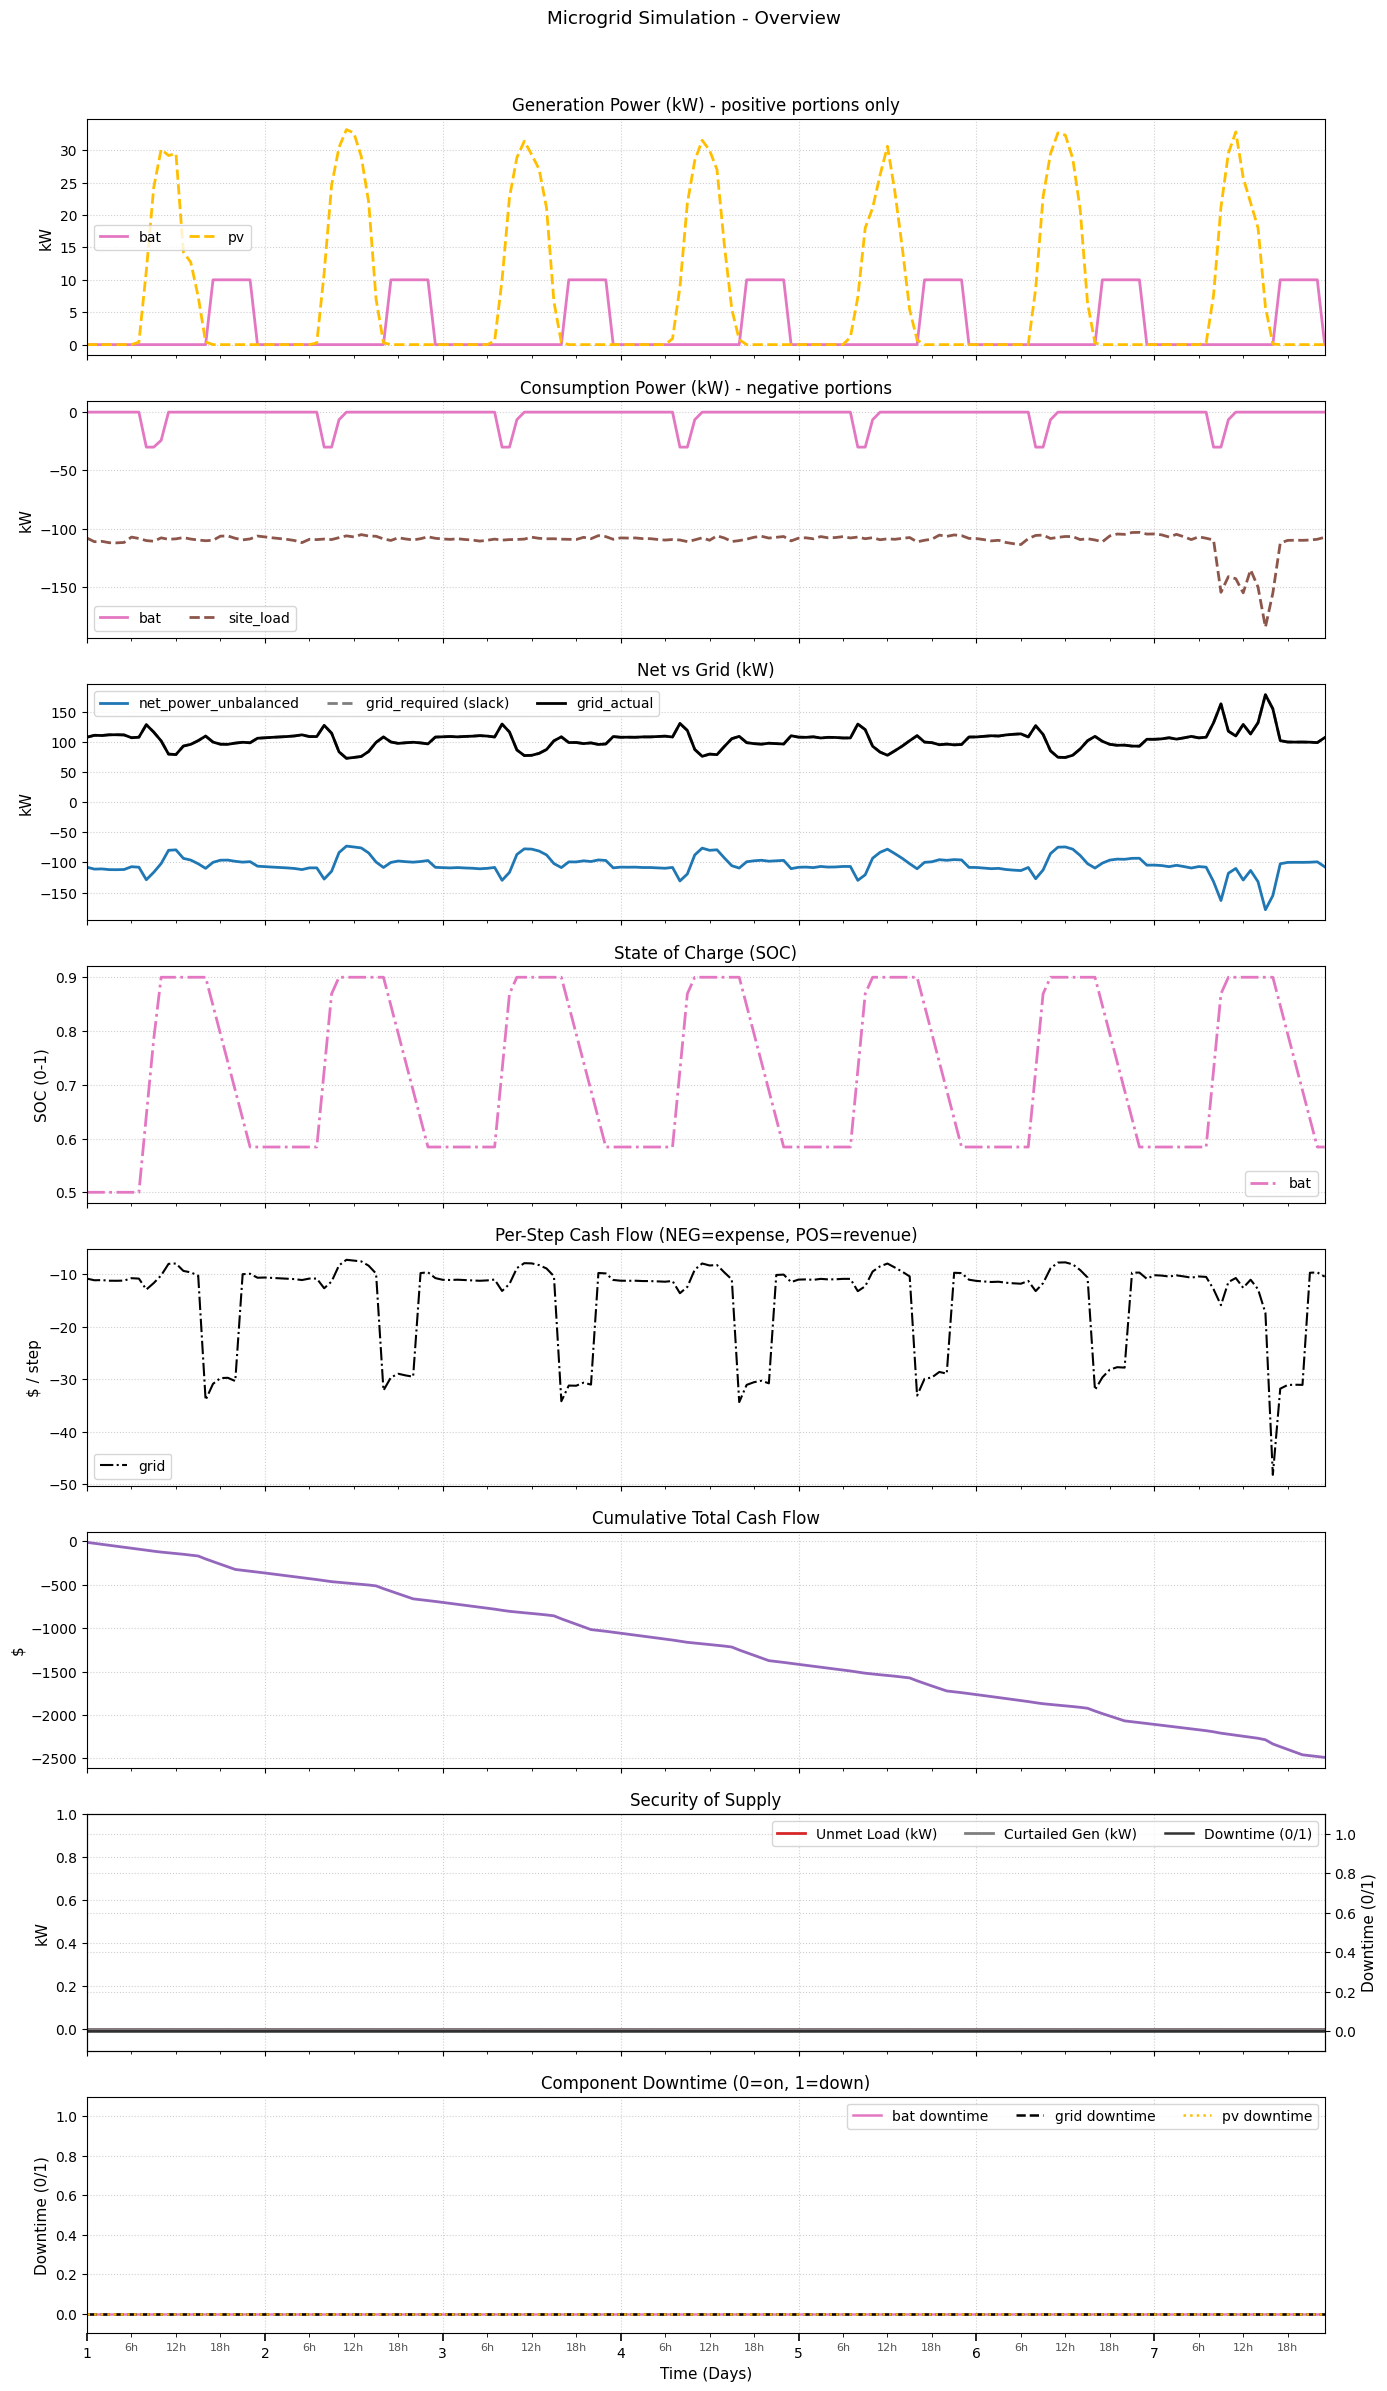

In [5]:
# Environment
from microgrid_sim.control.rules import TimeSchedule

env1 = MicrogridEnv(
    simulation_hours=total_hours,
    control_interval_minutes=control_dt,
    sim_dt_minutes=sim_dt
)

for c in (pv_mesa, site_load_mesa, bat_mesa):
    env1.add_component(c)
env1.add_component(grid_mesa, is_grid=True)
print("Environment 1 (Mesa) built with data-driven components.")

# Define Controller
rules_mesa = [
    BatteryRule(
        name="bat",
        charge_kw=-30.0,
        discharge_kw=10.0,
        charge_schedule=TimeSchedule(8, 17),
        discharge_schedule=TimeSchedule(17, 22),
        soc_min_trigger=0.1,
        soc_max_trigger=0.9
    ),
    RenewableDisconnectRule(name="pv"),
    GridRule(name="grid"),
]
ems_mesa = RuleBasedEMS(rules=rules_mesa)

# Run Simulation
print("Running Mesa data-driven simulation...")
env1.run(controller=ems_mesa, exogenous_list=exog_list_mesa)

# Results
df1 = env1.get_results()
_ = plot_simulation(df1, sim_dt_minutes=sim_dt, sim_name="04_mesa_replay_sim", save=True)
print("Mesa simulation complete.")

# Summary
total_cost_4 = df1["total_cashflow"].sum()
unmet_energy_4 = df1["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 4 Total Cost: ${total_cost_4:.2f}")
print(f"Scenario 4 Unmet Energy (kWh): {unmet_energy_4:.2f}")
df1.tail()

## Scenario 2 - Liège Data Replay

### Data Generation & Component Definitions

In [6]:
# Data Generation (LiegeDataBuilder)

LIEGE_DATA_PATH = "../data/liege"
data_builder_liege: DataBuilder = LiegeDataBuilder(
    folder_path = LIEGE_DATA_PATH,
    total_hours = total_hours,
    sim_dt_minutes = sim_dt,
    seed = seed
)

# Build the exogenous data list
exog_list_liege = data_builder_liege.build_list()
print(f"Built {len(exog_list_liege)} steps of data from Liège.")

# Components Definitions
pv_liege = ReplayGenerator("pv", time_step_minutes=sim_dt)

max_bat_kw_liege = 0.25
bat_liege = BatteryStorage("bat", capacity_kwh=max_bat_kw_liege*bat_hr_sizing, time_step_minutes=sim_dt, initial_soc=0.5)
site_load_liege = FactoryLoad("site_load", data_driven=True)

grid_liege = GridIntertie("grid", time_step_minutes=sim_dt,
                          price_import_per_kwh=0.20, price_export_per_kwh=0.05,
                          import_limit_kw=None)

Loading and resampling Liège dataset...
Cleaning raw data. Clamping PV to [0.0, 0.8] kW.
Clamping Load to [0.0, 0.3] kW.


c:\Users\olanr\Downloads\course-proj\microgrid-control-sim\microgrid_sim\data\liege_builder.py:72: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_load_resampled = df_load.resample(self.resample_str).mean()


Randomly selected start date: 2019-06-01T00:00:00.000000000
Note: Grid price data not included. Using synthetic prices.
Built 168 steps of data from Liège.


c:\Users\olanr\Downloads\course-proj\microgrid-control-sim\microgrid_sim\data\liege_builder.py:82: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_pv_resampled = df_pv.resample(self.resample_str).mean()
c:\Users\olanr\Downloads\course-proj\microgrid-control-sim\microgrid_sim\data\liege_builder.py:90: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_weather_resampled = df_weather.resample(self.resample_str).interpolate(method='linear')


### Build and Run Environment with Simple Controller

Environment 2 (Liège) built with data-driven components.
Running Liège data-driven simulation...
Liège simulation complete.
Scenario 4 Total Cost: $-0.04
Scenario 4 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,pv_downtime,grid_power,grid_cost,grid_downtime,bat_power,bat_cost,bat_soc,bat_downtime,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step (sim_dt),,,,,,,,,,,,,,,,,,,,,
163,0.0,0.0,0.0,99.835835,-31.059193,0.0,10.0,0.0,0.742105,0.0,...,0.0,-109.835835,10.0,99.835835,-99.835835,0.0,0.0,0.0,-31.059193,163.0
164,0.0,0.0,0.0,99.924724,-31.086847,0.0,10.0,0.0,0.689474,0.0,...,0.0,-109.924724,10.0,99.924724,-99.924724,0.0,0.0,0.0,-31.086847,164.0
165,0.0,0.0,0.0,99.689724,-9.697137,0.0,10.0,0.0,0.636842,0.0,...,0.0,-109.689724,10.0,99.689724,-99.689724,0.0,0.0,0.0,-9.697137,165.0
166,0.0,0.0,0.0,99.015557,-9.631559,0.0,10.0,0.0,0.584211,0.0,...,0.0,-109.015557,10.0,99.015557,-99.015557,0.0,0.0,0.0,-9.631559,166.0
167,0.0,0.0,0.0,107.301390,-10.437548,0.0,0.0,0.0,0.584211,0.0,...,0.0,-107.301390,0.0,107.301390,-107.301390,0.0,0.0,0.0,-10.437548,167.0


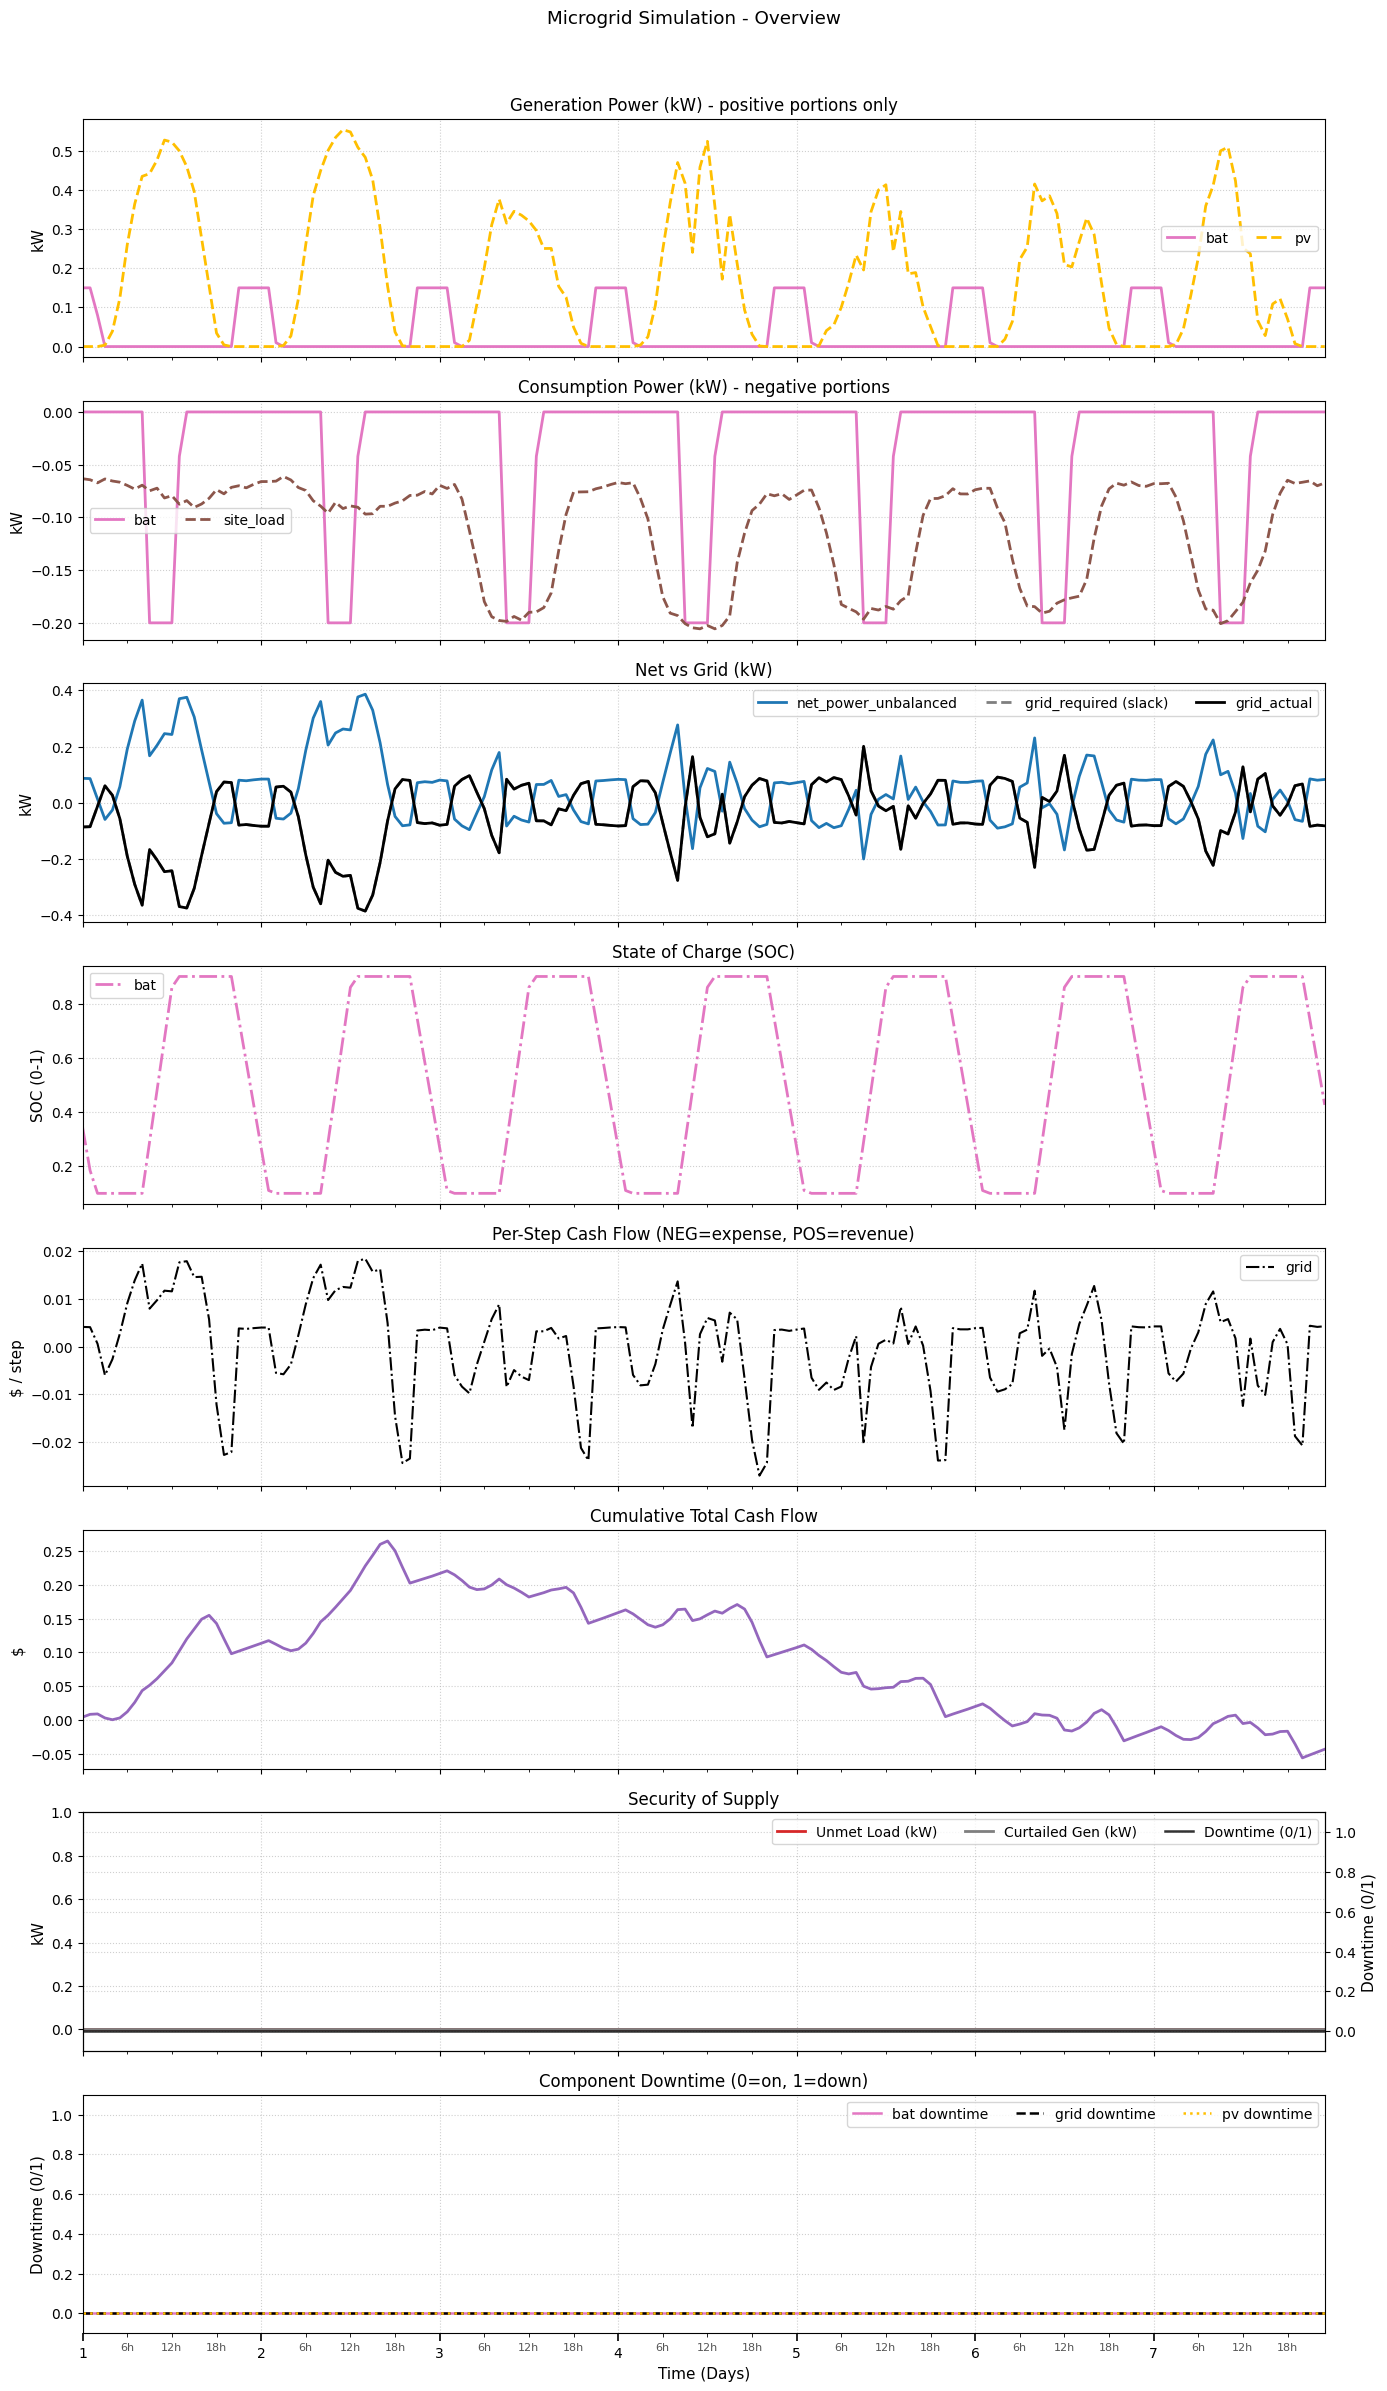

In [7]:
# Environment
env2 = MicrogridEnv(
    simulation_hours=total_hours,
    control_interval_minutes=control_dt,
    sim_dt_minutes=sim_dt
)

for c in (pv_liege, site_load_liege, bat_liege):
    env2.add_component(c)
env2.add_component(grid_liege, is_grid=True)
print("Environment 2 (Liège) built with data-driven components.")

# Controller
rules_liege = [
    BatteryRule(
        name="bat",
        charge_kw=-0.20,
        discharge_kw=0.15,
        charge_schedule=TimeSchedule(9, 14),
        discharge_schedule=TimeSchedule(21, 4),
        soc_min_trigger=0.1,
        soc_max_trigger=0.9
    ),
    RenewableDisconnectRule(name="pv"),
    GridRule(name="grid"),
]
ems_liege = RuleBasedEMS(rules=rules_liege)

# Simulation
print("Running Liège data-driven simulation...")
env2.run(controller=ems_liege, exogenous_list=exog_list_liege)

# Results
df2 = env2.get_results()
_ = plot_simulation(df2, sim_dt_minutes=sim_dt, sim_name="04_liege_replay_sim", save=True)
print("Liège simulation complete.")

# Summary
total_cost_4 = df2["total_cashflow"].sum()
unmet_energy_4 = df2["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 4 Total Cost: ${total_cost_4:.2f}")
print(f"Scenario 4 Unmet Energy (kWh): {unmet_energy_4:.2f}")
df1.tail()